# An introduction to PCA

Using principal component analysis to reveal latent structure in data

PCA is often used to reduce the dimensionality of large data while
preserving a significant amount of variance. More fundamentally, it is a
framework for studying the covariance statistics of data. In this
section, we will introduce the concept of PCA with some toy examples.

## A simple experiment

Let’s perform an imaginary neuroscience experiment! We’ll record
voltages from $P = 2$ neurons in visual cortex while the participant
passively views $N = 1000$ dots of different *colors* and *sizes*.

In [ ]:
# TODO uncomment before final packaging
# %pip install git+https://github.com/BonnerLab/ccn-tutorial.git


In [ ]:
from collections.abc import Sequence, Callable
import warnings
from typing import NamedTuple

import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
from matplotlib_inline.backend_inline import set_matplotlib_formats
import ipywidgets as widgets
from IPython.display import display, HTML


In [ ]:
%matplotlib inline

sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
    rc={"legend.edgecolor": "None"},
)
set_matplotlib_formats("svg")

pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", 10)
pd.set_option("display.precision", 3)
pd.set_option("display.show_dimensions", False)

xr.set_options(display_max_rows=3, display_expand_data=False)

warnings.filterwarnings("ignore")

In [ ]:
random_state = 0
rng = np.random.default_rng(seed=random_state)


### Creating the stimuli

Let’s create $N = 1000$ dots of different *colors* and *sizes*. From the
scatterplot, we can see that the two latent variables are
[uncorrelated](reference.qmd#correlation).

In [ ]:
def create_stimuli(
    n: int,
    *,
    rng: np.random.Generator,
) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "color": rng.random(size=(n,)),
            "size": rng.random(size=(n,)),
        }
    ).set_index(1 + np.arange(n))


In [ ]:
def view_stimuli(data: pd.DataFrame) -> Figure:
    fig, ax = plt.subplots()
    sns.scatterplot(
        ax=ax,
        data=data,
        x="color",
        y="size",
        hue="color",
        size="size",
        palette="flare",
        legend=False,
    )
    sns.despine(ax=ax, trim=True)
    fig.tight_layout()
    plt.close(fig)

    return fig


stimuli = create_stimuli(n=1_000, rng=rng)

view_stimuli(stimuli)


### Simulating neural responses

Now, let’s simulate some neural data. We need to decide how the $P = 2$
neurons might respond to these $N = 1000$ stimulus dots. Each neuron
could respond to either one or both of the latent features that define
these stimuli – $\text{color}$ and $\text{size}$. The neuron’s responses
could also be subject to noise.

Here, we model each neuron’s response $r_\text{neuron}$ as a simple
linear combination of the two latent features with stimulus-independent
Gaussian noise $\epsilon$:

$r_{\text{neuron}} \sim \beta_{\text{color}} \left( \text{color} \right) + \beta_{\text{size}} \left( \text{size} \right) + \epsilon$,
where
$\epsilon \sim \mathcal{N}(\mu_{\text{neuron}}, \sigma_{\text{neuron}}^2)$

In [ ]:
Neuron = NamedTuple(
    "Neuron",
    beta_color=float,
    beta_size=float,
    mean=float,
    std=float,
)


As we can see, each neuron’s response is completely defined by exactly
four parameters:

-   $\beta_{\text{color}}$ – how much the neuron cares about the
    stimulus $\text{color}$
-   $\beta_{\text{size}}$ – how much the neuron cares about the stimulus
    $\text{size}$
-   $\mu_{\text{neuron}}$ – the mean of the neuron’s responses
-   $\sigma_{\text{neuron}}^2$ – the stimulus-independent variance of
    the neuron’s responses

In [ ]:
def simulate_neuron_responses(
    stimuli: pd.DataFrame,
    neuron: Neuron,
    *,
    rng: np.random.Generator,
) -> np.ndarray:
    def z_score(x: np.ndarray) -> np.ndarray:
        return (x - x.mean()) / x.std()

    return (
        neuron.beta_color * z_score(stimuli["color"])
        + neuron.beta_size * z_score(stimuli["size"])
        + neuron.std * rng.standard_normal(size=(len(stimuli),))
        + neuron.mean
    )


In [ ]:
def simulate_multiple_neuron_responses(
    *,
    stimuli: pd.DataFrame,
    neurons: Sequence[Neuron],
    rng: np.random.Generator,
) -> xr.DataArray:
    data = []
    for i_neuron, neuron in enumerate(neurons):
        data.append(
            xr.DataArray(
                data=simulate_neuron_responses(
                    stimuli=stimuli,
                    neuron=neuron,
                    rng=rng,
                ),
                dims=("stimulus",),
                coords={
                    column: ("stimulus", values)
                    for column, values in stimuli.reset_index(names="stimulus").items()
                },
            )
            .expand_dims({"neuron": [i_neuron + 1]})
            .assign_coords(
                {
                    field: ("neuron", [float(value)])
                    for field, value in neuron._asdict().items()
                }
            )
        )

    return (
        xr.concat(data, dim="neuron")
        .rename("neuron responses")
        .transpose("stimulus", "neuron")
    )


This procedure produces a data matrix $X \in \mathbb{R}^{N \times P}$
containing the $P = 2$ neurons’ responses to the $N = 1000$ stimuli.

In [ ]:
neurons = (
    Neuron(beta_color=3, beta_size=-2, std=1, mean=7),
    Neuron(beta_color=-2, beta_size=5, std=3, mean=-6),
)

data = simulate_multiple_neuron_responses(
    stimuli=stimuli,
    neurons=neurons,
    rng=rng,
)

display(data)


## Understanding the neural code

How is this information encoded in the population activity? Is there a
neuron that is sensitive to color and another that is sensitive to size?

One way to understand this is by studying the neurons directly. Let’s
start by visualizing the response of each neuron to our stimuli. Note
that the below plots are 1-dimensional scatterplots; the spread along
the vertical axis is just for visualization purposes.

In [ ]:
def view_individual_scatter(
    data: xr.DataArray,
    *,
    coord: str,
    dim: str,
    template_func: Callable[[int], str],
) -> Figure:
    rng = np.random.default_rng()
    data_ = data.assign_coords(
        {"arbitrary": ("stimulus", rng.random(data.sizes["stimulus"]))}
    )
    min_, max_ = data_.min(), data_.max()

    n_features = data.sizes[dim]

    fig, axes = plt.subplots(nrows=n_features, figsize=(7, 2 * n_features))

    for index, ax in zip(data[coord].values, axes.flat):
        label = template_func(index)
        sns.scatterplot(
            ax=ax,
            data=(
                data_.isel({dim: data[coord].values == index})
                .rename(label)
                .to_dataframe()
            ),
            x=label,
            y="arbitrary",
            hue="color",
            size="size",
            palette="flare",
            legend=False,
        )
        sns.despine(ax=ax, left=True, offset=10)

        ax.set_xlim([min_, max_])
        ax.get_yaxis().set_visible(False)

    fig.tight_layout(h_pad=3)
    plt.close(fig)

    return fig


In [ ]:
view_individual_scatter(
    data,
    coord="neuron",
    dim="neuron",
    template_func=lambda x: f"neuron {x} response",
)


By visualizing the responses, we can see that each neuron is tuned to
both color *and* size.

We can also use methods such as Representational Similarity Analysis
(RSA)(Kriegeskorte 2008) to study the information content of the two
neurons. In RSA, the dissimilarity between the response of a system to
each pair of stimuli is obtained and represented in a matrix of
dissimilarities (a *representational dissimilarity matrix*, or RDM).
Therefore, an RDM indicates the degree to which each pair of stimuli is
distinguished by the neurons.

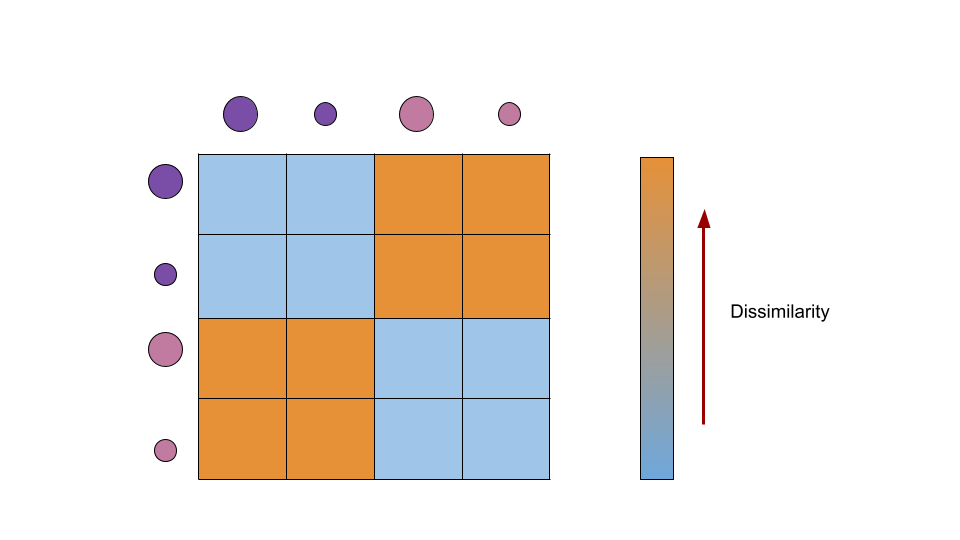

What if we want to study the underlying structure of this code? Is there
another view of the population code that might be more informative?

## Studying the latent dimensions

Instead of directly studying the neurons, we can focus on the underlying
factors that capture the structure and variance in the data.

### Some geometric intuition

Since we only have $P = 2$ neurons, we can visualize these data as a
scatterplot, which makes their [covariance](reference.qmd#covariance)
apparent.

In [ ]:
def view_joint_scatter(
    data: xr.DataArray,
    *,
    coord: str,
    dim: str,
    template_func: Callable[[int], str],
    draw_axes: bool = False,
) -> Figure:
    fig, ax = plt.subplots()

    data_ = pd.DataFrame(
        {coord_: data[coord_].values for coord_ in ("color", "size")}
        | {
            template_func(index): data.isel({dim: index - 1}).to_dataframe()[coord]
            for index in (1, 2)
        }
    )

    sns.scatterplot(
        ax=ax,
        data=data_,
        x=template_func(1),
        y=template_func(2),
        hue="color",
        size="size",
        legend=False,
        palette="flare",
    )
    if draw_axes:
        ax.axhline(0, c="gray", ls="--")
        ax.axvline(0, c="gray", ls="--")

    ax.set_aspect("equal", "box")
    sns.despine(ax=ax, offset=20)
    plt.close(fig)

    return fig


view_joint_scatter(
    data,
    coord="neuron responses",
    dim="neuron",
    template_func=lambda x: f"neuron {x} response",
)


We can use the covariance to change the way we view the data. Run the
animation below for demonstration.

In [ ]:
def animate_pca_transformation(
    data: xr.DataArray,
    *,
    durations: dict[str, int] = {
        "center": 1_000,
        "rotate": 1_000,
        "pause": 500,
    },
    interval: int = 50,
) -> str:
    def _compute_2d_rotation_matrix(theta: float) -> np.ndarray:
        return np.array(
            [
                [np.cos(theta), -np.sin(theta)],
                [np.sin(theta), np.cos(theta)],
            ]
        )

    fig = view_joint_scatter(
        data,
        coord="neuron responses",
        dim="neuron",
        template_func=lambda x: f"neuron {x} response",
        draw_axes=True,
    )
    ax = fig.get_axes()[0]
    scatter = ax.get_children()[0]
    title = fig.suptitle("neuron responses")

    n_frames = {key: value // interval + 1 for key, value in durations.items()}

    x_mean, y_mean = data.mean("stimulus").values
    delta = np.array([x_mean, y_mean]) / n_frames["center"]

    _, _, v_h = np.linalg.svd(data - data.mean("stimulus"))
    v = v_h.transpose()
    theta = np.arccos(v[0, 0])
    rotation = _compute_2d_rotation_matrix(-theta / n_frames["rotate"])

    transformed = (data - data.mean("stimulus")).values @ v

    radius = max(np.linalg.norm(transformed, axis=-1))
    limit = max(np.abs(data).max(), np.abs(transformed).max(), radius)
    ax.set_xlim([-limit, limit])
    ax.set_ylim([-limit, limit])
    fig.tight_layout()

    frame_to_retitle_center = 2 * n_frames["pause"]
    frame_to_start_centering = frame_to_retitle_center + n_frames["pause"]
    frame_to_stop_centering = frame_to_start_centering + n_frames["center"]
    frame_to_retitle_rotate = frame_to_stop_centering + n_frames["pause"]
    frame_to_start_rotating = frame_to_retitle_rotate + n_frames["pause"]
    frame_to_stop_rotating = frame_to_start_rotating + n_frames["rotate"]
    frame_to_retitle_transformed = frame_to_stop_rotating + n_frames["pause"]
    frame_to_end = frame_to_retitle_transformed + 2 * n_frames["pause"]

    def _update(frame: int) -> None:
        if frame < frame_to_retitle_center:
            return
        elif frame == frame_to_retitle_center:
            title.set_text("step 1 of 2: center the data")
            ax.set_xlabel("")
            ax.set_ylabel("")
        elif frame < frame_to_start_centering:
            return
        elif frame <= frame_to_stop_centering:
            scatter.set_offsets(scatter.get_offsets() - delta)
        elif frame == frame_to_retitle_rotate:
            title.set_text("step 2 of 2: rotate the data")
        elif frame < frame_to_start_rotating:
            return
        elif frame <= frame_to_stop_rotating:
            scatter.set_offsets(scatter.get_offsets().data @ rotation)
        elif frame < frame_to_retitle_transformed:
            return
        elif frame == frame_to_retitle_transformed:
            title.set_text("principal components")
            ax.set_xlabel("principal component 1")
            ax.set_ylabel("principal component 2")
        elif frame <= frame_to_end:
            return

    animation = FuncAnimation(
        fig=fig,
        func=_update,
        frames=frame_to_end,
        interval=interval,
        repeat=False,
    )
    plt.close(fig)
    return animation.to_html5_video()


# display(HTML(animate_pca_transformation(data)))


> **Tip**
>
> Click on the animation above to visualize the PCA transformation!

As seen in the animation, we can transform our data to view the
directions of maximum variance. These directions are the principal
components of our data.

### The mathematical definition

Given a data matrix $X \in \mathbb{R}^{N \times P}$, we need to compute
the [eigendecomposition](reference.qmd#eigendecomposition)[1] of its
[covariance](reference.qmd#auto-covariance)[2]:

$$
\begin{align*}
    \text{cov}(X)
    &= \left(\dfrac{1}{n - 1}\right) (X - \overline{X})^\top (X - \overline{X})\\
    &= V \Lambda V^\top
\end{align*}
$$

To do this, we start by computing the covariance of our data matrix,
where $X$ is centered (i.e. $X - \overline{X}$)



Next , we compute the the eigendecomposition of the covariance (though
the computational steps we take to get there are slightly different, as
shown later)



The columns of $V$ are *eigenvectors* that specify the directions of
variance while the corresponding diagonal elements of $\Lambda$ are
*eigenvalues* that specify the amount of variance along the
eigenvector[3].

Finally, the original data matrix can be transformed by projecting it
onto the eigenvectors:
$\widetilde{X} = \left(X - \overline{X}\right) V$.



> **Viewing PCA as an optimization**
>
> PCA can be used to project data into a lower-dimensional space
> (i.e. $p \le f$) in a way that best preserves the geometry of the
> data. Specifically, computing a PCA decomposition of $X$ yields a
> matrix $V \in \mathbb{R}^{f \times p}$ such that
> $V = \argmin_{V \in \mathbb{U_{f \times p}}} \sum_{i=1}^n \left|| x_i - VV^\top x_i \right||_2$,
> where $||\cdot||_2$ denotes the $L_2$-norm and
> $\mathbb{U_{f \times p}}$ denotes the set of orthonormal matrices with
> shape $f \times p$.

### A computational recipe

1.  Center the data matrix.
2.  Compute its singular value decomposition[4].
3.  The right singular vectors $V$ of the data matrix are the
    eigenvectors of its covariance.
4.  The singular values $\Sigma$ of the data matrix are related to the
    eigenvalues $\Lambda$ of its covariance as
    $\Lambda = \Sigma^2 / (N - 1)$
5.  To project data from the ambient space to the latent space, we must
    subtract the mean computed in Step 1, and multiply the data by the
    eigenvectors.

[1] The eigendecomposition of a symmetric matrix
$X \in \mathbb{R}^{n \times n}$ involves rewriting it as the product of
three matrices $X = V \Lambda V^\top$, where $V \in \mathbb{n \times n}$
is orthonormal and $\Lambda \in \mathbb{n \times n}$ is diagonal with
non-negative entries.

[2] Given a data matrix $X \in \mathbb{R}^{n \times f}$ containing
neural responses to $n$ stimuli from $f$ neurons, the *auto-covariance*
of $X$ (or simply its *covariance*) is defined as:

$$\text{cov}(X) = \left(\dfrac{1}{n - 1}\right) (X - \overline{X})^\top (X - \overline{X})$$

This is an $f \times f$ matrix where the $(i, j)$-th element measures
how much neuron $i$ covaries with neuron $j$. If the covariance is
positive, they tend to have similar activation: a stimulus that
activates one neuron will tend to activate the other. If the covariance
is negative, the neurons will have dissimilar activation: a stimulus
that activates one neuron will likely not activate the other.

[3] Let’s compute the covariance of the projected data $\widetilde{X}$:

$$
\begin{align*}
    \text{cov}(\widetilde{X})
    &= \left(\dfrac{1}{n - 1}\right) \widetilde{X}^\top \widetilde{X}\\
    &= \left(\dfrac{1}{n - 1}\right) \left((X - \overline{X})V\right)^\top \left((X - \overline{X})V\right)\\
    &= \left(\dfrac{1}{n - 1}\right) V^\top (X - \overline{X})^\top (X - \overline{X})V\\
    &= V^\top \left(\dfrac{1}{n - 1}\right) (X - \overline{X})^\top (X - \overline{X})V\\
    &= V^\top \left( V \Lambda V^\top \right) V\\
    &= I \Lambda I\\
    &= \Lambda
\end{align*}
$$

[4] The singular value decomposition (SVD) involves rewriting a matrix
$X \in \mathbb{R}^{m \times n}$ as the product of three matrices
$X = U \Sigma V^\top$, where $U \in \mathbb{R}^{m \times m}$ and
$V \in \mathbb{R}^{n \times n}$ are orthonormal matrices and
$\Sigma \in \mathbb{R}^{m \times n}$ is zero everywhere except
potentially on its leading diagonal

In [ ]:
class PCA:
    def __init__(self) -> None:
        self.mean: np.ndarray
        self.eigenvectors: np.ndarray
        self.eigenvalues: np.ndarray

    def fit(self, /, data: np.ndarray) -> None:
        self.mean = data.mean(axis=-2)

        data_centered = data - self.mean
        _, s, v_t = np.linalg.svd(data_centered)

        n_stimuli = data.shape[-2]

        self.eigenvectors = np.swapaxes(v_t, -1, -2)
        self.eigenvalues = s**2 / (n_stimuli - 1)

    def transform(self, /, data: np.ndarray) -> np.ndarray:
        return (data - self.mean) @ self.eigenvectors


> **Why do we compute PCA this way instead of
> $\text{eig}(\text{cov}(X))$?**
>
> To apply PCA to a data matrix, we might be tempted to use the
> definition and naively compute its
> [covariance](reference.qmd#auto-covariance) followed by an
> [eigendecomposition](reference.qmd#eigendecomposition). However, when
> the number of neurons $P$ is large, this approach is memory-intensive
> and prone to numerical errors.
>
> Instead, we can use the [singular value
> decomposition](reference.qmd#singular-value-decomposition) (SVD) of
> $X$ to efficiently compute its PCA transformation. Specifically,
> $X = U \Sigma V^\top$ is a singular value decomposition, where $U$ and
> $V$ are orthonormal and $\Sigma$ is diagonal.
>
> The covariance matrix reduces to
> $X^\top X / (n - 1) = V \left(\frac{\Sigma^2}{n - 1} \right) V^\top$,
> which is exactly the eigendecomposition required.
>
> Specifically, the eigenvalues $\lambda_i$ of the covariance matrix are
> related to the singular values $\sigma_i$ of the data matrix as
> $\lambda_i = \sigma_i^2 / (N - 1)$, while the eigenvectors of the
> covariance matrix are exactly the right singular vectors $V$ of the
> data matrix $X$.

> **Only need the first few PCs?**
>
> Check out [truncated
> SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)!

## Transforming the dataset

Let’s now project our data into its principal components and analyse it
in this space.

In [ ]:
def compute_pca(data: xr.DataArray) -> xr.Dataset:
    pca = PCA()
    pca.fit(data.values)

    data_transformed = pca.transform(data.values)

    return xr.Dataset(
        data_vars={
            "score": xr.DataArray(
                data=data_transformed,
                dims=("stimulus", "component"),
            ),
            "eigenvector": xr.DataArray(
                data=pca.eigenvectors,
                dims=("component", "neuron"),
            ),
        },
        coords={
            "rank": ("component", 1 + np.arange(data_transformed.shape[-1])),
            "eigenvalue": ("component", pca.eigenvalues),
        }
        | {coord: (data[coord].dims[0], data[coord].values) for coord in data.coords},
    )


pca = compute_pca(data)
display(pca["score"])


### Inspecting the eigenvectors

The eigenvectors represent the directions of maximum variance in our
data.

In [ ]:
with xr.set_options(display_expand_data=True):
    display(pca["eigenvector"])


### Interpreting the transformed data

We can view the data projected onto each of the principal components.

In [ ]:
view_individual_scatter(
    pca["score"],
    coord="rank",
    dim="component",
    template_func=lambda x: f"principal component {x}",
)


We observe that:

-   the *first* principal component is largely driven by the *size* of
    the stimulus
-   the *second* principal component is largely driven by the *color* of
    the stimulus

> **Important**
>
> Note that these components do *not* directly correspond to either of
> the latent variables. Rather, each is a mixture of stimulus-dependent
> signal and noise.

### Inspecting the eigenspectrum

The eigenvalues show the variance along each eigenvector. The sum of the
eigenvalues is therefore equal to the total variance.

In [ ]:
eigenvalues = pca["eigenvalue"].round(3)
for i_neuron in range(eigenvalues.sizes["component"]):
    print(
        f"variance along eigenvector {i_neuron + 1} (eigenvalue {i_neuron + 1}):"
        f" {eigenvalues[i_neuron].values}"
    )
print(f"total variance: {eigenvalues.sum().values}")


We can also see that this is equal to the total variance in the original
data.

In [ ]:
variances = data.var(dim="stimulus", ddof=1).round(3).rename("neuron variances")
for i_neuron in range(variances.sizes["neuron"]):
    print(f"variance of neuron {i_neuron + 1} responses: {variances[i_neuron].values}")
print(f"total variance: {variances.sum().values}")


We can plot the eigenvalues as a function of their rank to visualize the
*eigensceptrum*. As we will see shortly, the eigenspectrum provides
valuable insights about the laten dimensionality of the data.

In [ ]:
def view_eigenspectrum(pca: xr.DataArray) -> Figure:
    fig, ax = plt.subplots(figsize=(pca.sizes["component"], 5))
    sns.lineplot(
        ax=ax,
        data=pca["component"].to_dataframe(),
        x="rank",
        y="eigenvalue",
        marker="s",
    )
    ax.set_xticks(pca["rank"].values)
    ax.set_ylim(bottom=0)
    sns.despine(ax=ax, offset=20)
    plt.close(fig)

    return fig


view_eigenspectrum(pca)


## Quantifying dimensionality

In these data, the dimensionality is clear: there are two latent
variables and both are evident in the principal components. However, in
real data, we typically record from more than $P = 2$ neurons, therefore
judging the dimensionality becomes tricky. To simulate such a scenario,
let’s record from more neurons (say $P = 10$).

In [ ]:
def _simulate_random_neuron(rng: np.random.Generator) -> Neuron:
    return Neuron(
        beta_color=rng.integers(-10, 11),
        beta_size=rng.integers(-10, 11),
        std=rng.integers(-10, 11),
        mean=rng.integers(-10, 11),
    )


neurons = tuple([_simulate_random_neuron(rng) for _ in range(10)])

big_data = simulate_multiple_neuron_responses(
    stimuli=stimuli,
    neurons=neurons,
    rng=rng,
)

display(big_data)


As before, we can visualize each the principal component and plot the
eigenspectrum:

In [ ]:
big_pca = compute_pca(big_data)

view_individual_scatter(
    big_pca["score"],
    coord="rank",
    dim="component",
    template_func=lambda x: f"principal component {x}",
)


In [ ]:
view_eigenspectrum(big_pca)


We know by design that this data was generated from *2* latent variables
– *color* and *size*. However, in real datasets with naturalistic
stimuli, we often don’t know what the latent variables are! It’s common
to use the eigenspectrum to estimate the latent dimensionality of the
data. For instance, inspecting the eigenspectrum of our toy example
tells us that the first two dimensions have much higher variance than
the rest. We refer to these as the *effective dimensions*.

In general, there are several approaches for estimating dimensionality
based on the eigenspectrum:

#### Rank of the covariance matrix

The *rank* of the covariance matrix – equal to the number of *nonzero*
eigenvalues – would be the latent dimensionality in the ideal setting
where the data has zero noise. In real data, the rank is typically equal
to the ambient dimensionality (which here is the number of neurons we
record from), since there is typically some variance along every
dimension.

In [ ]:
print(f"rank = {(big_pca.eigenvalue > 0).sum().values}")


def view_thresholded_eigenspectrum(pca: PCA, *, threshold: int | float) -> Figure:
    fig = view_eigenspectrum(pca)
    ax = fig.get_axes()[0]

    ax.axhline(threshold, ls="--", c="gray")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.fill_between(x=xlim, y1=ylim[-1], y2=threshold, color="green", alpha=0.1)
    ax.fill_between(x=xlim, y1=ylim[0], y2=threshold, color="red", alpha=0.1)

    return fig


view_thresholded_eigenspectrum(big_pca, threshold=0)


#### Setting an arbitrary variance threshold

Though not typically used today, another approach is to set an arbitrary
threshold on the variance (historically recommended as $1$ for
normalized data); only dimensions with variance above that threshold are
considered useful.

In [ ]:
view_thresholded_eigenspectrum(big_pca, threshold=150)


#### Setting an arbitrary *cumulative* variance threshold

A very commonly used method is to set a threshold based on the
cumulative variance of the data: the number of dimensions required to
exceed, say $80\%$ of the variance, is taken as the latent
dimensionality.

In [ ]:
def view_cumulative_eigenspectrum(
    pca: xr.DataArray, *, threshold: float = 0.8
) -> Figure:
    fig, ax = plt.subplots(figsize=(pca.sizes["component"], 5))

    data = pca["eigenvalue"].copy()
    data["eigenvalue"] = data.cumsum()
    data = data.rename({"eigenvalue": "cumulative variance"})
    data["cumulative proportion of variance"] = (
        data["cumulative variance"] / pca["eigenvalue"].sum()
    )

    sns.lineplot(
        ax=ax,
        data=data.to_dataframe(),
        x="rank",
        y="cumulative variance",
        marker="s",
    )
    ax.set_xticks(pca["rank"].values)

    ax_twin = ax.twinx()
    ax_twin.set_ylabel("cumulative proportion of variance")

    ax_twin.axhline(threshold, ls="--", c="gray")
    xlim = ax_twin.get_xlim()
    ylim = ax_twin.get_ylim()

    ax_twin.fill_between(x=xlim, y1=ylim[-1], y2=threshold, color="red", alpha=0.1)
    ax_twin.fill_between(x=xlim, y1=ylim[0], y2=threshold, color="green", alpha=0.1)

    sns.despine(ax=ax, offset=20)
    sns.despine(ax=ax_twin, offset=20, left=True, bottom=True, right=False, top=True)
    ax_twin.yaxis.set_major_formatter(ticker.PercentFormatter(1))

    fig.tight_layout()
    plt.close(fig)

    return fig


view_cumulative_eigenspectrum(big_pca)


#### Eyeballing the “knee” of the spectrum

When the number of latent dimensions is low, eigenspectra often have a
sharp discontinuity (the “knee”), where a small number of dimensions
have high-variance and the remainder have much have lower variance. The
latent dimensionality is then taken to be the number of dimensions above
this threshold determined by eye.

In [ ]:
def view_eigenspectrum_knee(pca: PCA, *, knee: int) -> Figure:
    fig = view_eigenspectrum(pca)
    ax = fig.get_axes()[0]
    ax.plot(
        knee,
        big_pca["eigenvalue"].isel({"component": big_pca["rank"] == knee}).values,
        "o",
        ms=30,
        mec="r",
        mfc="none",
        mew=3,
    )

    ax.axvline(knee, ls="--", c="gray")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.fill_betweenx(y=ylim, x1=xlim[-1], x2=knee, color="red", alpha=0.1)
    ax.fill_betweenx(y=ylim, x1=xlim[0], x2=knee, color="green", alpha=0.1)

    return fig


view_eigenspectrum_knee(big_pca, knee=3)


So far, all of the techniques discussed depend on a paramter that needs
to be decided by the researcher. For instance, a cumulative threshold of
80% is an arbitrary choice, and if we decided to choose 90% instead, we
would get a different number of dimensions. This is why sometimes a
parameter-free estimate is preferred.

#### Computing a summary statistic over the entire spectrum

A metric such as *effective dimensionality* summarizes the spectrum
using an entropy-like measure, taking into account variances along all
the dimensions:

$$d_\text{eff}(\lambda_1, \dots \lambda_n) = \dfrac{\left( \sum_{i=1}^n \lambda_i \right)^2}{\sum_{i=1}^n \lambda_i^2}$$

In [ ]:
def compute_effective_dimensionality(eigenspectrum: np.ndarray) -> float:
    return (np.sum(eigenspectrum) ** 2) / (eigenspectrum**2).sum()


def view_effective_dimensionality_examples(pca: PCA) -> Figure:
    n_components = pca.sizes["component"]

    spectrum_1 = [float(pca["eigenvalue"].mean().values)] * n_components

    weights = 1 / (1 + np.arange(n_components, dtype=np.float32))
    weights /= weights.sum()

    spectrum_2 = list(weights * pca["eigenvalue"].sum().values)
    spectrum_3 = [float(pca["eigenvalue"].sum().values)] + [0] * (n_components - 1)

    data = pd.DataFrame(
        {
            "eigenvalue": spectrum_1 + spectrum_2 + spectrum_3,
            "rank": list(np.tile(pca["rank"].values, 3)),
            "example": [0] * n_components + [1] * n_components + [2] * n_components,
        }
    )
    # return data
    g = sns.relplot(
        kind="line",
        data=data,
        col="example",
        x="rank",
        y="eigenvalue",
        marker="o",
        height=3,
        aspect=1,
        facet_kws={
            "sharey": False,
        },
    )

    for i_spectrum, ax in enumerate(g.axes.flat):
        d = compute_effective_dimensionality(
            data.loc[data["example"] == i_spectrum, "eigenvalue"]
        )
        ax.set_title("$d_{eff}$" + f" = {d.round(2)}")
        ax.set_xticks([1, 10])

    sns.despine(g.figure, offset=10)
    g.figure.tight_layout(w_pad=2)
    plt.close(g.figure)
    return g.figure


print(
    "effective dimensionality ="
    f" {compute_effective_dimensionality(big_pca['eigenvalue']).values.round(2)}"
)

view_effective_dimensionality_examples(big_pca)


## Takeaways and further thoughts

-   PCA is a useful tool for studying the neural code and estimating the
    latent dimensionality of representations.
-   However, PCA focuses on how much variance is present along each
    dimension, and not the usefulness of the dimensions.
-   Here we used a toy example with idealized data, where the high
    variance dimensions are meaninful and the low variance ones are
    noise.
-   This may not always be the case, we could instead have high variance
    noise dimensions, and low variance meaningful dimensions.
-   Later in the tutorial, we will discuss more powerful techniques that
    can handle such problems. But before that, let’s analyze a real
    neuroscience dataset.

## Additional notes

### Preprocessing the data

Before PCA, it’s often recommended to preprocess the data by Z-scoring
each of the input features $X$ – ensuring that they have zero mean and
unit variance:

$$Z = \dfrac{X - \mu}{\sigma}$$

> **When and why should we standardize the data?**
>
> Often, PCA is applied to data where the features are fundamentally
> different from each other. For example, we might have a dataset where
> the features of interest are the prices of cars (in dollars) and their
> masses (in kilograms). Since these two features have different units,
> the variances of the features are not directly comparable – there’s no
> obvious way to numerically compare a variance of
> (\$20,000)<sup>2</sup> in price and a variance of (1,000
> kg)<sup>2</sup> in mass. Even if the features being compared are all
> the same, if they are in different units – say euros, dollars, and
> cents – the raw variances of the data matrix are meaningless.
>
> Since PCA implicitly assumes that the variances along each dimension
> are comparable, we can Z-score each of the features before applying
> PCA to ensure that they are on a common scale.
>
> Note, however, that this transformation reduces the information in the
> system – it is possible that the variances of the features are
> informative.

## Further reading

1.  [This StackOverflow
    answer](https://stats.stackexchange.com/a/134283) is a great
    explanation for how [singular value
    decomposition](reference.qmd#singular-value-decomposition) is
    related to principal component analysis.
2.  [This tutorial](https://doi.org/10.1080/00273171.2020.1743631) by
    Giudice (2020) on effective dimensionality provides a great overview
    of different notions of dimensionality and metrics to quantify it.

Giudice, Marco Del. 2020. “Effective Dimensionality: A Tutorial.”
*Multivariate Behavioral Research* 56 (3): 527–42.
<https://doi.org/10.1080/00273171.2020.1743631>.

Kriegeskorte, Nikolaus. 2008. “Representational Similarity Analysis
Connecting the Branches of Systems Neuroscience.” *Frontiers in Systems
Neuroscience*. <https://doi.org/10.3389/neuro.06.004.2008>.